## Basic Setup

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Adjusting Path for this Notebook

In [2]:
cd drive/'My Drive'/'Colab Notebooks'/'Emotion Speech Recognition'/

/content/drive/My Drive/Colab Notebooks/Emotion Speech Recognition


In [3]:
# Now above cell output is our path which is in current working directory
!ls

'[CNN]speech_emotion_recognition.ipynb'
 Dataset
 dataset_attr.csv
 demo_audio.wav
 features_dataframe
 images
'[LSTM]speech_emotion_recognition.ipynb'
 model.json
 Predictions.csv
 Trained_Models
 utils


## Installation of Packages

- Importing libraries whenever the wants.

## Plotting the audio file's waveform and its spectrogram

In [4]:
import librosa
data, sampling_rate = librosa.load('Dataset/anger/anger016.wav')
# To play audio this in the jupyter notebook
import IPython.display as ipd
ipd.Audio('Dataset/anger/anger016.wav')

Populating the interactive namespace from numpy and matplotlib


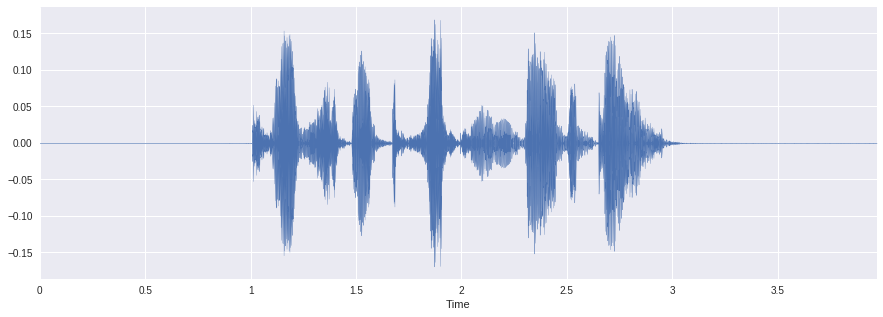

In [5]:
% pylab inline
import librosa.display
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## Setup the Basic Paramter

In [0]:
import os

dataset_path = os.path.abspath('./Dataset')
destination_path = os.path.abspath('./')
# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000 
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]


## Setting the labels

In [0]:
# loading dataframes using dataset module 
from utils import dataset
df, train_df, test_df = dataset.create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [8]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

Dataset samples  :  2556 
Training Samples :  2044 
testing Samples  :  512


In [9]:
df.head()

,path,label
0,/content/drive/My Drive/Colab Notebooks/Emotio...,3
1,/content/drive/My Drive/Colab Notebooks/Emotio...,2
2,/content/drive/My Drive/Colab Notebooks/Emotio...,2
3,/content/drive/My Drive/Colab Notebooks/Emotio...,0
4,/content/drive/My Drive/Colab Notebooks/Emotio...,3



### # Labels Assigned for emotions : 
- 0 : anger
- 1 : disgust
- 2 : fear
- 3 : happy
- 4 : neutral 
- 5 : sad
- 6 : surprise


In [10]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])


Actual Audio :  /content/drive/My Drive/Colab Notebooks/Emotion Speech Recognition/Dataset/happy/happy279.wav
Labels       :  3


## Getting the features of audio files using librosa

Calculating MFCC, Pitch, magnitude, Chroma features.

In [0]:
import pandas as pd
from utils.feature_extraction import get_features_dataframe
from utils.feature_extraction import get_audio_features

# trainfeatures, trainlabel = get_the_features(train_df, sampling_rate)
# testfeatures, testlabel = get_the_features(test_df, sampling_rate)

# I have ran above 2 lines and get the featured dataframe. 
# and store it into pickle file to use it for later purpose.
# it take too much time to generate features(around 30-40 minutes).

trainfeatures = pd.read_pickle('./features_dataframe/trainfeatures')
trainlabel = pd.read_pickle('./features_dataframe/trainlabel')
testfeatures = pd.read_pickle('./features_dataframe/testfeatures')
testlabel = pd.read_pickle('./features_dataframe/testlabel')





In [12]:
trainfeatures.shape

(2044, 65)

In [0]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [0]:
import numpy as np

# By using .ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()


In [15]:
y_train[:5]

array([3, 2, 2, 0, 3])

In [16]:
# One-Hot Encoding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

Using TensorFlow backend.


In [17]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Changing dimension for CNN model

In [0]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [19]:
x_traincnn.shape

(2044, 65, 1)

In [0]:
import keras
from keras.layers import LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input, 
from keras.layers import Dense #, Embedding

In [0]:
hidden_units = x_traincnn.shape[1]*2

In [25]:
hidden_units*3//4

97

In [0]:
model = Sequential()

model.add(LSTM(hidden_units,return_sequences=True, input_shape=(x_traincnn.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(hidden_units, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM((hidden_units*3)//4))
model.add(Dropout(0.2))


model.add(Dense(y_train.shape[1]))

model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

# model.add(LSTM(hidden_units, input_shape=(x_traincnn.shape[1], 1)))
# model.add(LSTM(hidden_units))
# model.add(Dense(y_train.shape[1]))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 65, 130)           68640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 65, 130)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 65, 130)           135720    
_________________________________________________________________
dropout_5 (Dropout)          (None, 65, 130)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 97)                88464     
_________________________________________________________________
dropout_6 (Dropout)          (None, 97)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 686       
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [0]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=380, validation_data=(x_testcnn, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 2044 samples, validate on 512 samples
Epoch 1/380
2044/2044 [==============================] - 58s 28ms/step - loss: 1.9420 - acc: 0.1663 - val_loss: 1.9404 - val_acc: 0.1660
Epoch 2/380
2044/2044 [==============================] - 48s 24ms/step - loss: 1.9344 - acc: 0.1732 - val_loss: 1.9349 - val_acc: 0.1855
Epoch 3/380
2044/2044 [==============================] - 49s 24ms/step - loss: 1.9258 - acc: 0.1678 - val_loss: 1.9306 - val_acc: 0.1582
Epoch 4/380
2044/2044 [==============================] - 48s 24ms/step - loss: 1.9196 - acc: 0.1810 - val_loss: 1.9286 - val_acc: 0.1582
Epoch 5/380
2044/2044 [==============================] - 48s 24ms/step - loss: 1.9175 - acc: 0.1580 - val_loss: 1.9281 - val_acc: 0.1582
Epoch 6/380
2044/2044 [==============================] - 48s 24ms/step - loss: 1.9142 - acc: 0.1830 - val_loss: 1.9279 - val_acc: 0.1582
Epoch 7/380
 960/2044 [=============>................] - ETA: 23s - loss: 1.8982 - 

In [0]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [0]:
model_name = 'Speech_Emotion_Recognition_Model.h5'
save_dir = os.path.join(os.getcwd(), 'Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [0]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [0]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

## Predicting emotions on the test data

In [0]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

In [0]:
preds

In [0]:
preds1=preds.argmax(axis=1)

In [0]:
preds1

In [0]:
abc = preds1.astype(int).flatten()

In [0]:
predictions = (lb.inverse_transform((abc)))

In [0]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [0]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [0]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [0]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [0]:
finaldf[170:180]

In [0]:
finaldf.groupby('actualvalues').count()

In [0]:
finaldf.groupby('predictedvalues').count()

In [0]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [0]:
demo_audio_path = './Dataset/disgust/disgust009.wav'

In [0]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path,sampling_rate)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)
demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [0]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [0]:
demo_audio_features.shape

In [0]:
livepreds = loaded_model.predict(demo_audio_features, 
                         batch_size=32, 
                         verbose=1)

In [0]:
livepreds

In [0]:
# emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
index = livepreds.argmax(axis=1).item()
index

In [0]:
emotions[index]